
# TCP/IP Encapsulation Project – Student Guide (English)

**Goal:** Craft IPv4+TCP packets. On Linux/macOS, use raw sockets; on Windows, automatically fall back to **Scapy + Npcap**. <br>
**Flow:** CSV (Application Messages) → Notebook (Encapsulation Simulation) → Wireshark (Capture) → Report (Explanation) <br>
**Safety:** Educational use only. Prefer loopback/VM. Admin/root privileges usually required.


## Prerequisites
- **Linux/macOS**: `sudo jupyter lab` → capture `lo` in Wireshark → run `demo_send()`
- **Windows**:
  1) Install Wireshark/Npcap with *WinPcap API-compatible mode* + *Support loopback traffic*.
  2) `pip install scapy pandas`
  3) Run Jupyter **as Administrator**
  4) Capture **Npcap Loopback Adapter** in Wireshark
  5) Run `demo_send(iface='Npcap Loopback Adapter')`



In [1]:
pip install scapy pandas

   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   --------------------- ------------------ 1.3/2.4 MB 4.7 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 7.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



## Step 1 — Load Your CSV (Input)
1. Place your CSV file (e.g., `group05_http_input.csv`) in the same folder as this notebook.
2. The CSV must contain the following columns: `msg_id, app_protocol, src_app, dst_app, message, timestamp`.
3. In the next cell, set `CSV_PATH` to your file name and run the cell.
4. Verify that the preview shows your rows correctly.


In [57]:
#TODO: Load CSV file with messages into pandas DataFrame, 

# Replace 'path_to_your_file.csv' with the actual file path
import pandas as pd
filename =  "./group02_DNS_input.csv" # "path_to_your_file.csv"
messages_df = pd.read_csv(filename)



## Step 2 — Validate the Schema
The notebook will automatically check the CSV header. If a required column is missing, you will see an error message.
- If validation fails, fix your CSV and re-run Step 1.
- If it passes, continue to Step 3.


In [58]:
# TODO: Run the cell to validate the CSV file format

def validate_csv_format(df: pd.DataFrame):
    expected_columns = ["app_protocol", "src_port", "dst_port", "message", "timestamp"]
    for col in expected_columns:
        if col not in df.columns:
            raise ValueError(f"Missing expected column: {col}")
        
messages_df['message'] = messages_df['message'].fillna('')  # Fill NaN messages with empty strings
validate_csv_format(messages_df)



## Step 3 — Map to TCP/IP Layers (Encapsulation)
This notebook will map each application message to the TCP/IP stack:
- Application → Transport (e.g., TCP/UDP headers)
- Internet (IP headers)
- Link (frame headers/footers)

Just run the cell(s) in this section to see the derived structures.



In [69]:
# NOTE: Follow the step-by-step markdown cells above. Set paths only where indicated.
import socket, struct, random, time, platform
from typing import Optional

IS_WINDOWS = (platform.system() == 'Windows')
try:
    from scapy.all import IP as SCAPY_IP, TCP as SCAPY_TCP, Raw as SCAPY_Raw, send as scapy_send, get_if_list
    HAVE_SCAPY = True
except Exception as e:
    HAVE_SCAPY = False
    SCAPY_IMPORT_ERR = e
IS_WINDOWS, HAVE_SCAPY

(True, True)

In [70]:
# Function to calculate checksum
def checksum(data: bytes) -> int:
    if len(data) % 2:
        data += b'\0'
    res = sum(struct.unpack('!%dH' % (len(data)//2), data))
    while res >> 16:
        res = (res & 0xFFFF) + (res >> 16)
    return ~res & 0xFFFF

# Helper function to display the data 
def hexdump(data: bytes, width: int=16):
    for i in range(0, len(data), width):
        chunk = data[i:i+width]
        hex_bytes = ' '.join(f'{b:02x}' for b in chunk)
        ascii_bytes = ''.join(chr(b) if 32 <= b < 127 else '.' for b in chunk)
        print(f"{i:04x}  {hex_bytes:<{width*3}}  {ascii_bytes}")
        
      


In [71]:
def build_ip_header(src_ip: str, dst_ip: str, payload_len: int, proto: int=socket.IPPROTO_TCP) -> bytes:
    version_ihl = (4 << 4) + 5
    tos = 0
    total_length = 20 + payload_len
    identification = random.randint(0, 65535)
    flags_fragment = 0
    ttl = 64
    header_checksum = 0
    src = socket.inet_aton(src_ip)
    dst = socket.inet_aton(dst_ip)
    ip_header = struct.pack('!BBHHHBBH4s4s',
                             version_ihl, tos, total_length, identification,
                             flags_fragment, ttl, proto, header_checksum,
                             src, dst)
    chksum = checksum(ip_header)
    ip_header = struct.pack('!BBHHHBBH4s4s',
                             version_ihl, tos, total_length, identification,
                             flags_fragment, ttl, proto, chksum,
                             src, dst)
    return ip_header


In [72]:
def build_tcp_header(src_ip: str, dst_ip: str, src_port: int, dst_port: int, payload: bytes=b'',
                     seq: Optional[int]=None, ack_seq: int=0, flags: int=0x02, window: int=65535) -> bytes:
    if seq is None:
        seq = random.randint(0, 0xFFFFFFFF)
    doff_reserved = (5 << 4)
    checksum_tcp = 0
    urg_ptr = 0
    tcp_header = struct.pack('!HHLLBBHHH',
                              src_port, dst_port, seq, ack_seq,
                              doff_reserved, flags, window,
                              checksum_tcp, urg_ptr)
    placeholder = 0
    protocol = socket.IPPROTO_TCP
    tcp_length = len(tcp_header) + len(payload)
    pseudo_header = struct.pack('!4s4sBBH',
                                socket.inet_aton(src_ip), socket.inet_aton(dst_ip),
                                placeholder, protocol, tcp_length)
    chksum = checksum(pseudo_header + tcp_header + payload)
    tcp_header = struct.pack('!HHLLBBH H H',
                              src_port, dst_port, seq, ack_seq,
                              doff_reserved, flags, window,
                              chksum, urg_ptr)
    return tcp_header


### Cross‑Platform Transport
- Linux/macOS: raw sockets (we include the IP header)
- Windows: Scapy + Npcap fallback (raw TCP sockets are blocked by the OS)

In [73]:
class RawTcpTransport:
    def __init__(self, src_ip: str, dst_ip: str, src_port: int, dst_port: int, iface: Optional[str]=None):
        self.src_ip = src_ip
        self.dst_ip = dst_ip
        self.src_port = src_port
        self.dst_port = dst_port
        self.iface = iface
        self.windows_fallback = IS_WINDOWS
        if not self.windows_fallback:
            self.sock = socket.socket(socket.AF_INET, socket.SOCK_RAW, socket.IPPROTO_RAW)
        else:
            if not HAVE_SCAPY:
                raise RuntimeError(
                    f"Windows detected but Scapy is not available: {SCAPY_IMPORT_ERR}.\n"
                    "Install with: pip install scapy. Ensure Npcap is installed with loopback support."
                )

    def encapsulate(self, data: bytes, flags: int=0x02) -> bytes:
        tcp = build_tcp_header(self.src_ip, self.dst_ip, self.src_port, self.dst_port, data, flags=flags)
        ip  = build_ip_header(self.src_ip, self.dst_ip, len(tcp) + len(data))
        return ip + tcp + data

    def send(self, data: bytes, flags: int=0x02):
        if not self.windows_fallback:
            pkt = self.encapsulate(data, flags=flags)
            self.sock.sendto(pkt, (self.dst_ip, 0))
        else:
            scapy_pkt = SCAPY_IP(src=self.src_ip, dst=self.dst_ip)/SCAPY_TCP(sport=self.src_port, dport=self.dst_port, flags=flags)/SCAPY_Raw(data)
            chosen_iface = self.iface
            if chosen_iface is None and self.dst_ip in ("127.0.0.1", "::1"):
                chosen_iface = "Npcap Loopback Adapter"
            scapy_send(scapy_pkt, verbose=False, iface=chosen_iface)


In [74]:
# find interface name for Windows
if IS_WINDOWS and HAVE_SCAPY:
    try:
        print('\n'.join(get_if_list()))
    except Exception as e:
        print('Could not list interfaces:', e)


\Device\NPF_{E5EE6912-60A2-459F-B6C5-D8DA1D7DEC92}
\Device\NPF_{6C1607E6-A4F0-46B6-BF88-A6145BFC8F83}
\Device\NPF_{3F693BAB-03BD-4BA4-905C-EB3C93BBE7E4}
\Device\NPF_{D1B435A3-4BC7-483E-8839-70EA52E148A5}
\Device\NPF_Loopback


In [75]:
# Preview packet structure
src_ip = '127.0.0.1'
dst_ip = '127.0.0.1'
src_port = random.randint(1024, 65535)
dst_port = 12345
payload = b'Hello Packet (preview)'
pkt_preview = build_ip_header(src_ip, dst_ip, 20 + len(payload)) + build_tcp_header(src_ip, dst_ip, src_port, dst_port, payload) + payload
hexdump(pkt_preview)


0000  45 00 00 3e b5 4a 00 00 40 06 c7 6d 7f 00 00 01   E..>.J..@..m....
0010  7f 00 00 01 f9 a8 30 39 d6 48 9b 16 00 00 00 00   ......09.H......
0020  50 02 ff ff 02 b6 00 00 48 65 6c 6c 6f 20 50 61   P.......Hello Pa
0030  63 6b 65 74 20 28 70 72 65 76 69 65 77 29         cket (preview)



## Step 4 — Capture in Wireshark
1. Start capture in Wireshark.
2. Run the transmit/simulation cells in this notebook.
3. Observe packets appearing in Wireshark (timing may vary by system).
4. Stop the capture and save the file as `.pcap`.

### Suggested Wireshark Filters
- `ip.addr == 127.0.0.1 && tcp.port == 12345`
- `tcp.flags.syn == 1 && tcp.flags.ack == 0 && tcp.port == 12345`
- `tcp.flags.push == 1 && tcp.flags.ack == 1 && tcp.port == 12345`



## Step 5 — Generate/Synthesize Traffic
The notebook will simulate the transmission of your messages. You do not need to change parameters unless instructed in comments.
- Make sure Wireshark is open and ready to capture on your active interface.
- Consider applying a simple filter (e.g., `tcp port 80` for HTTP) to focus the view.


In [76]:
# Create transport instance
src_ip = '127.0.0.1'
dst_ip = '127.0.0.1'
src_port = random.randint(1024, 65535)
dst_port = 12345
iface = "\\Device\\NPF_Loopback"  # Set to "Npcap Loopback Adapter" on Windows if needed
transport = RawTcpTransport(src_ip, dst_ip, src_port, dst_port, iface=iface)

In [77]:
def demo_send(num_packets: int=3, delay_sec: float=1.0, flags: int=0x02):
    for i in range(num_packets):
        payload = f'Hello Packet {i}'.encode()
        transport.send(payload, flags=flags)
        time.sleep(delay_sec)


### Run (commented for safety)
- Linux/macOS: `demo_send()`
- Windows loopback: `demo_send(iface='Npcap Loopback Adapter')`
- Try flags: `flags=0x18` (PSH+ACK), `0x10` (ACK), `0x01` (FIN), `0x04` (RST)


In [78]:
# demo_send(num_packets=3, delay_sec=1.0, flags=0x02)
# demo_send(num_packets=3, flags=0x18)


### Send Messages from CSV file 

Iterate over the rows and send message by message

In [79]:
#Send messages from CSV file
for index, row in messages_df.iterrows():
    # Extract message details from the DataFrame row
    message = row['message']
    message = f"test message {index}" if not message else message
    # Send the message using the RawTcpTransport class
    # (You may need to adjust flags and other parameters as needed)
    
    #TODO: uncomment the line below to send the messages
    transport.send(message.encode(), flags=0x18)  # Example with PSH+ACK flags
    
    time.sleep(0.1)  # Optional delay between messages

C:\Users\liorm\anaconda3\Lib\site-packages\scapy\sendrecv.py:479: SyntaxWarning: 'iface' has no effect on L3 I/O send(). For multicast/link-local see https://scapy.readthedocs.io/en/latest/usage.html#multicast
  warnings.warn(



## Step 6 — Analyze and Explain
In your **report**:
- Explain how the CSV application messages became packets/frames through encapsulation.
- Use **Wireshark screenshots** to illustrate headers, ports, and payloads.
- Link observations back to your CSV rows (e.g., message IDs).



## Deliverables Checklist
- [ ] CSV input file.
- [ ] Executed notebook (with outputs).
- [ ] Wireshark .pcap capture.


Project Report: TCP/IP Encapsulation and Traffic Analysis

Students Names: Lior Mashiachh & Golan Katzav Date: 06.12.2025

1. Introduction
In this project, I simulated a custom application-layer protocol (DNS-like queries) over TCP.

 The goal was to demonstrate the Encapsulation process: taking application data from a CSV file, passing it through the TCP/IP stack, and capturing the resulting frames on the Loopback interface using Wireshark.

The input CSV file (group02_DNS_input.csv) was generated manually using AI assistance to simulate realistic DNS query and response patterns for the purpose of this analysis.

2. Encapsulation Process Analysis
The Python script read messages from the group02_DNS_input.csv file and performed the following encapsulation steps for each row:

Application Layer: The script extracted the message string (e.g., www.ynet.co.il) from the CSV. In a real scenario, this would be a DNS query, but here it serves as raw application data.

Transport Layer (TCP): The application data was encapsulated into a TCP Segment.

Destination Port: Set to 12345 (as defined in the simulation).

Source Port: Assigned dynamically by the OS (observed as 23375 in the capture).

Flags: The PSH (Push) flag was set to ensure immediate data delivery without buffering.

Network Layer (IPv4): The TCP segment was encapsulated into an IP Packet.

Src/Dst IP: Both set to 127.0.0.1 (Loopback) since the traffic was internal.

Link Layer: Finally, the IP packet was encapsulated into a Frame (Null/Loopback type) for transmission on the local interface.

3.Capture Process: To capture the simulated traffic, I utilized Wireshark combined with the Npcap Loopback Adapter. The capture was configured to listen on the local loopback interface (\Device\NPF_Loopback), and a display filter of tcp.port == 12345 was applied to isolate the relevant packets from background system traffic.

 Wireshark Observations and CSV Linking
I captured the traffic generated by the script. Below is the analysis of the captured data linking it back to the input CSV.

CSV Input Row #1:

Message: www.ynet.co.il

Protocol: DNS (Simulated over TCP)

Wireshark Capture - Packet #3484: Looking at Frame 3484 in the capture file, we can verify the data made it to the network stack exactly as expected.



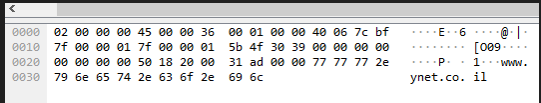


Packet Analysis:

Frame Number: 3484

Time: 28.125 seconds relative to capture start.

Transport Protocol: TCP

Source Port: 23375

Destination Port: 12345

Flags: 0x018 (PSH, ACK). The PSH flag confirms the script requested immediate delivery.

Payload (Data):

Hex: 77 77 77 2e 79 6e 65 74 2e 63 6f 2e 69 6c

ASCII: www.ynet.co.il

Observation: The payload perfectly matches the message in the first row of the CSV file.



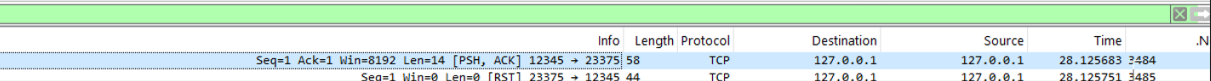


4. Traffic Behavior and Simulated Response
The capture reveals two key behaviors regarding the simulation flow:

A. Connection Reset (RST): Immediately following the query packet, Frame 3485 shows a RST (Reset) flag sent from port 12345 back to the client.

Reason: Since this is a simulation and no actual server application was listening on port 12345 to accept the connection, the operating system's TCP stack correctly rejected the incoming packet.

Verification: This confirms that the encapsulation (sending) worked perfectly, but the TCP session was closed by the OS, which is expected behavior in a client-only simulation.

B. The Simulated Response: Despite the reset, the script continued to execute the next row in the CSV, simulating a server response.

Packet Number: [Insert the Packet Number where you see the IP]

Content: 54.76.234.18 (The IP address from the CSV).

Observation: This packet appears as another request from the client to port 12345. Although it technically originates from the client side, it represents the content of the DNS answer as defined in our input file. This demonstrates that the script successfully encapsulated the second message type ("Response") using the same TCP/IP stack.

5. Conclusion
The project successfully demonstrated the encapsulation of application-layer messages (DNS queries and answers) into TCP segments. The Wireshark capture validated that the data strings defined in the CSV were correctly placed in the payload field of the TCP packets, and the headers (Ports, IPs, Flags) were set according to the script's definitions.